# 📃 Solution for Exercise M4.04

In the previous notebook, we saw the effect of applying some regularization
on the coefficient of a linear model.

In this exercise, we will study the advantage of using some regularization
when dealing with correlated features.

We will first create a regression dataset. This dataset will contain 2,000
samples and 5 features from which only 2 features will be informative.

In [1]:
from sklearn.datasets import make_regression

data, target, coef = make_regression(
    n_samples=2_000,
    n_features=5,
    n_informative=2,
    shuffle=False,
    coef=True,
    random_state=0,
    noise=30,
)

When creating the dataset, `make_regression` returns the true coefficient
used to generate the dataset. Let's plot this information.

Relevant feature #0     9.566665
Relevant feature #1    40.192077
Noisy feature #0        0.000000
Noisy feature #1        0.000000
Noisy feature #2        0.000000
dtype: float64

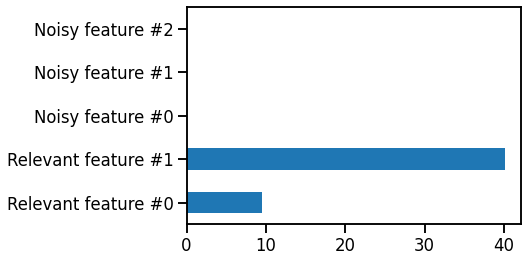

In [2]:
import pandas as pd

feature_names = [
    "Relevant feature #0",
    "Relevant feature #1",
    "Noisy feature #0",
    "Noisy feature #1",
    "Noisy feature #2",
]
coef = pd.Series(coef, index=feature_names)
coef.plot.barh()
coef

Create a `LinearRegression` regressor and fit on the entire dataset and
check the value of the coefficients. Are the coefficients of the linear
regressor close to the coefficients used to generate the dataset?

In [3]:
# solution
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
linear_regression.fit(data, target)
linear_regression.coef_

array([10.89587004, 40.41128042, -0.20542454, -0.18954462,  0.11129768])

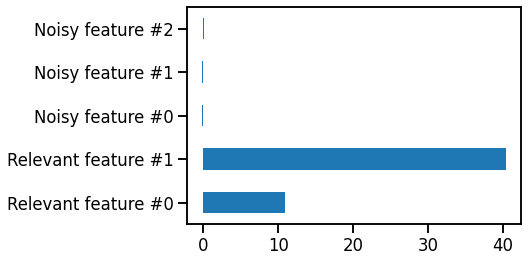

In [4]:
feature_names = [
    "Relevant feature #0",
    "Relevant feature #1",
    "Noisy feature #0",
    "Noisy feature #1",
    "Noisy feature #2",
]
coef = pd.Series(linear_regression.coef_, index=feature_names)
_ = coef.plot.barh()

We see that the coefficients are close to the coefficients used to generate
the dataset. The dispersion is indeed cause by the noise injected during the
dataset generation.

Now, create a new dataset that will be the same as `data` with 4 additional
columns that will repeat twice features 0 and 1. This procedure will create
perfectly correlated features.

In [5]:
# solution
import numpy as np

data = np.concatenate([data, data[:, [0, 1]], data[:, [0, 1]]], axis=1)

Fit again the linear regressor on this new dataset and check the
coefficients. What do you observe?

In [6]:
# solution
linear_regression = LinearRegression()
linear_regression.fit(data, target)
linear_regression.coef_

array([ 1.81143870e+15, -2.10014256e+13, -2.19253372e-01, -2.51228987e-01,
        5.65998472e-02, -9.05719348e+14, -2.88975896e+13, -9.05719347e+14,
        4.98990152e+13])

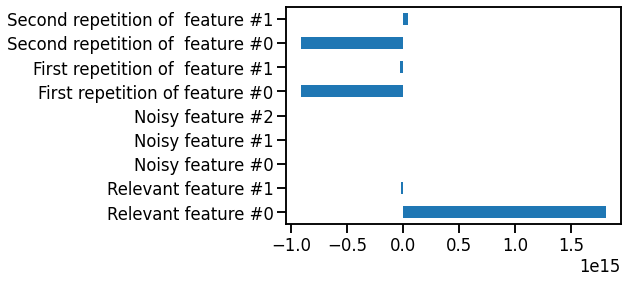

In [7]:
feature_names = [
    "Relevant feature #0",
    "Relevant feature #1",
    "Noisy feature #0",
    "Noisy feature #1",
    "Noisy feature #2",
    "First repetition of feature #0",
    "First repetition of  feature #1",
    "Second repetition of  feature #0",
    "Second repetition of  feature #1",
]
coef = pd.Series(linear_regression.coef_, index=feature_names)
_ = coef.plot.barh()

We see that the coefficient values are far from what one could expect.
By repeating the informative features, one would have expected these
coefficients to be similarly informative.

Instead, we see that some coefficients have a huge norm ~1e14. It indeed
means that we try to solve an mathematical ill-posed problem. Indeed, finding
coefficients in a linear regression involves inverting the matrix
`np.dot(data.T, data)` which is not possible (or lead to high numerical
errors).

Create a ridge regressor and fit on the same dataset. Check the coefficients.
What do you observe?

In [8]:
# solution
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(data, target)
ridge.coef_

array([ 3.6313933 , 13.46802113, -0.20549345, -0.18929961,  0.11117205,
        3.6313933 , 13.46802113,  3.6313933 , 13.46802113])

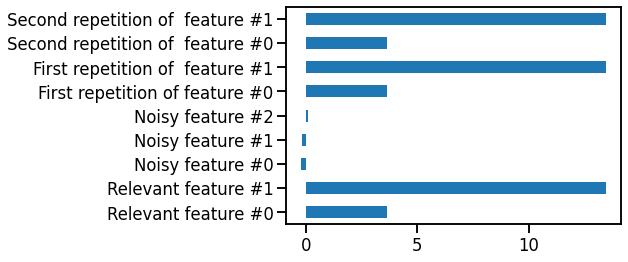

In [9]:
coef = pd.Series(ridge.coef_, index=feature_names)
_ = coef.plot.barh()

We see that the penalty applied on the weights give a better results: the
values of the coefficients do not suffer from numerical issues. Indeed, the
matrix to be inverted internally is `np.dot(data.T, data) + alpha * I`.
Adding this penalty `alpha` allow the inversion without numerical issue.

Can you find the relationship between the ridge coefficients and the original
coefficients?

In [10]:
# solution
ridge.coef_[:5] * 3

array([10.89417991, 40.40406338, -0.61648035, -0.56789883,  0.33351616])

Repeating three times each informative features induced to divide the
ridge coefficients by three.

<div class="admonition tip alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;">Tip</p>
<p>We advise to always use a penalty to shrink the magnitude of the weights
toward zero (also called "l2 penalty"). In scikit-learn, <tt class="docutils literal">LogisticRegression</tt>
applies such penalty by default. However, one needs to use <tt class="docutils literal">Ridge</tt> (and even
<tt class="docutils literal">RidgeCV</tt> to tune the parameter <tt class="docutils literal">alpha</tt>) instead of <tt class="docutils literal">LinearRegression</tt>.</p>
<p class="last">Other kinds of regularizations exist but will not be covered in this course.</p>
</div>

## Dealing with correlation between one-hot encoded features

In this section, we will focus on how to deal with correlated features that
arise naturally when one-hot encoding categorical features.

Let's first load the Ames housing dataset and take a subset of features that
are only categorical features.

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

ames_housing = pd.read_csv("../datasets/house_prices.csv", na_values='?')
ames_housing = ames_housing.drop(columns="Id")

categorical_columns = ["Street", "Foundation", "CentralAir", "PavedDrive"]
target_name = "SalePrice"
X, y = ames_housing[categorical_columns], ames_housing[target_name]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)


We previously presented that a `OneHotEncoder` creates as many columns as
categories. Therefore, there is always one column (i.e. one encoded category)
that can be inferred from the others. Thus, `OneHotEncoder` creates
collinear features.

We illustrate this behaviour by considering the "CentralAir" feature that
contains only two categories:

In [12]:
X_train["CentralAir"]

618     Y
870     N
92      Y
817     Y
302     Y
       ..
763     Y
835     Y
1216    Y
559     Y
684     Y
Name: CentralAir, Length: 1168, dtype: object

In [13]:
from sklearn.preprocessing import OneHotEncoder

single_feature = ["CentralAir"]
encoder = OneHotEncoder(sparse=False, dtype=np.int32)
X_trans = encoder.fit_transform(X_train[single_feature])
X_trans = pd.DataFrame(
    X_trans,
    columns=encoder.get_feature_names_out(input_features=single_feature),
)
X_trans

,CentralAir_N,CentralAir_Y
0,0,1
1,1,0
2,0,1
3,0,1
4,0,1
...,...,...
1163,0,1
1164,0,1
1165,0,1
1166,0,1



Here, we see that the encoded category "CentralAir_N" is the opposite of the
encoded category "CentralAir_Y". Therefore, we observe that using a
`OneHotEncoder` creates two features having the problematic pattern observed
earlier in this exercise. Training a linear regression model on such a
of one-hot encoded binary feature can therefore lead to numerical
problems, especially without regularization. Furthermore, the two one-hot
features are redundant as they encode exactly the same information in
opposite ways.

Using regularization helps to overcome the numerical issues that we highlighted
earlier in this exercise.

Another strategy is to arbitrarily drop one of the encoded categories.
Scikit-learn provides such an option by setting the parameter `drop` in the
`OneHotEncoder`. This parameter can be set to `first` to always drop the
first encoded category or `binary_only` to only drop a column in the case of
binary categories.

In [14]:
encoder = OneHotEncoder(drop="first", sparse=False, dtype=np.int32)
X_trans = encoder.fit_transform(X_train[single_feature])
X_trans = pd.DataFrame(
    X_trans,
    columns=encoder.get_feature_names_out(input_features=single_feature),
)
X_trans

,CentralAir_Y
0,1
1,0
2,1
3,1
4,1
...,...
1163,1
1164,1
1165,1
1166,1



We see that only the second column of the previous encoded data is kept.
Dropping one of the one-hot encoded column is a common practice,
especially for binary categorical features. Note however that this breaks
symmetry between categories and impacts the number of coefficients of the
model, their values, and thus their meaning, especially when applying
strong regularization.

Let's finally illustrate how to use this option is a machine-learning pipeline:

In [15]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(OneHotEncoder(drop="first", dtype=np.int32), Ridge())
model.fit(X_train, y_train)
n_categories = [X_train[col].nunique() for col in X_train.columns]
print(
    f"R2 score on the testing set: {model.score(X_test, y_test):.2f}"
)
print(
    f"Our model contains {model[-1].coef_.size} features while "
    f"{sum(n_categories)} categories are originally available."
)

R2 score on the testing set: 0.24
Our model contains 9 features while 13 categories are originally available.
